# Certificate in Data Science | Assignment 3 |  
> University of Washington, Seattle, WA    
> December 2019  
> N. Hicks

## Problem Statement  

A superstore wants to identify customer groupings that visit their stores based on customer transaction (sales) data. These groupings are used for targeted promotions. You are asked to perform customer segmentation on the provided data.  
> **Perform each of the following tasks and answer the related questions:**  
> 1. Import the data into a dataframe.  
> 2. Calculate the Recency, Frequency, Monitary (RFM) results of each customer.
> 3. Using K-means algorithm, perform customer segmentation.
> 6. Describe your findings.

## Import Libraries

In [1]:
'''
Import Required Libraries
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime as dt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from matplotlib import cm

## Establish the Dataset

### Global Variables

In [2]:
'''
Set the resultant plot parameters.
RETURN: none.
'''
%matplotlib inline

# set for all notebook; width, height of the resulting plots
plt.rcParams["figure.figsize"] = [10, 7]

sns.set()

In [3]:
random_var = 42   # the random state variable

### Functions for Scripting

In [4]:
'''
Retrieve the prescribed dataset.
RETURN: pd.DataFrame
'''
def fetch_data(path, file):
    try:
        # import the file to a dataframe
        _df = pd.read_csv(path + file)
        print('REMOTE FILE USED')
    except:
        # Local Copy -- Link would not permit access
        path = os.getcwd()
        print('LOCAL FILE USED;\nREMOTE SERVER NOT REACHABLE\n--> [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:590)\n\n')
        # import the file to a dataframe
        _df = pd.read_csv(os.path.join(path, file))
    
    return _df

In [5]:
'''
Create a scale function for a single feature.
RETURN: a scaled column feature
'''
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

In [6]:
'''
Build a histogram plot of the primary features
RETURN: seaborn.distplot
'''
def hist_plot(df, col):
    sns.distplot(df[col], bins=50, hist=True)
    plt.title('HISTOGRAM OF SELECTED FEATURE')
    plt.show()

In [7]:
'''
Encode the feature element into an updated feature.
RETURN: dtype(string) (an updated 'Product ID' feature)
'''
def encode_feature(_df, arr, val):
    codes_cat = ['FUR', 'OFF', 'TEC']
    codes_sub = ['BO', 'CH', 'LA', 'TA', 'ST', 'FU', 'AR',
                 'PH', 'BI', 'AP', 'PA', 'AC', 'EN',
                 'FA', 'SU', 'MA', 'CO']
    
    i = 1   # designate the first 'Product ID' digit as > 0
    for code in codes_cat:
        # ['Furniture' 'Office Supplies' 'Technology']
        code_val = val[0:3]
        
        # first, check if the prefix is contained within the code array
        if code_val in codes_cat:   # if TRUE, the 'Product ID' is not yet encoded
            if code_val == code:
                j = 1   # designate the second 'Product ID' digit as > 0
                for code_sub in codes_sub:
                    code_val_sub = val[4:6]
                    # ['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
                    # 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
                    # 'Fasteners' 'Supplies' 'Machines' 'Copiers']        
                    if code_val_sub == code_sub:
                        if j<10: k = str(0) + str(j)
                        else: k = str(j)
                        cat = str(i) + k + val[7:]
                        return cat
                    j += 1
        i += 1

In [8]:
'''
A function to process the recency, frequency, and monetary parameters (RFM).
utilizes the original DataFrame as input to assess the results.
RETURNS: pd.DataFrame
'''
def rfm_result(Start_Date_Obj, End_Date_Obj, Time_Window, FM_Window):
    check_point_date = Start_Date_Obj
    UserID = []
    Checkpoint = []
    Recency = []
    Frequency = []
    Monetary_Value = []
    Monetary_Quantity = []
    while check_point_date <= End_Date_Obj:
        window_start = check_point_date - dt.timedelta(days = Time_Window)
        mask = (store_df['Order Date'] >= window_start) & (store_df['Order Date'] < check_point_date)
        # Get the data in [checkpoint-60days, checkpoint]
        data_checkpoint = store_df.loc[mask]
        # Get the ids of users who have activities in [checkpoint-60days, checkpoint]
        unique_users = list(set(data_checkpoint['Customer ID']))
        print("There are %d unique users."%(len(unique_users)))
        FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
        for user in unique_users:
            UserID.append(user)
            Checkpoint.append(check_point_date)
            mask = data_checkpoint['Customer ID'] == user
            data_checkpoint_user = data_checkpoint.loc[mask]
            delta = check_point_date - max(data_checkpoint_user['Order Date'])
            recency = delta.days
            mask = data_checkpoint_user['Order Date'] >= FM_Window_Start
            data_checkpoint_user_fm = data_checkpoint_user.loc[mask]
            frequency = data_checkpoint_user_fm.shape[0]
            value = np.sum(round(data_checkpoint_user_fm.iloc[:, 17], 2))
            quantity = np.sum(data_checkpoint_user_fm.iloc[:, 18])
            Recency.append(recency)              # delta days between check-point and the last transaction time
            Frequency.append(frequency)          # per 'FM_Window' time period: how many times the end-user interacted with the system
            Monetary_Value.append(value)         # per 'FM_Window' time period: how much time and money the end-user interacted with the system
            Monetary_Quantity.append(quantity)   # the number of items acquired by end-user from the system
        check_point_date = check_point_date + dt.timedelta(days = 1)
    # Consolidate all columns into a signle data frame
    RFM_Dict = OrderedDict([('Customer ID', UserID),
                            ('Checkpoint', Checkpoint),
                            ('Recency',  Recency),
                            ('Frequency', Frequency),
                            ('Value', Monetary_Value),
                            ('Quantity', Monetary_Quantity)]
                          )
    RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)
    return RFM_Frame

### Import the Data

In [9]:
path = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/'
file = 'SuperstoreTransaction.csv'
store_df = fetch_data(path, file)

REMOTE FILE USED


## Explore the Data  
> Basic data integrity

In [10]:
store_df.head(25)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
5,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
6,7,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800,4,0.00,1.9656
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152
8,9,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3,0.20,5.7825
9,10,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000,5,0.00,34.4700


In [11]:
store_df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [12]:
# describe all unique attributes of all dataset features
features_all = store_df.columns
print('THE UNIQUE VALUES OF ALL DATASET FEATURES')
print('=========================================')
for feature in features_all:
    val = store_df[feature].unique()
    print('\n' + feature + ' ({}):\n{}'.format(len(val), val))

THE UNIQUE VALUES OF ALL DATASET FEATURES

Row ID (9994):
[   1    2    3 ... 9992 9993 9994]

Order ID (5009):
['CA-2016-152156' 'CA-2016-138688' 'US-2015-108966' ... 'CA-2014-110422'
 'CA-2017-121258' 'CA-2017-119914']

Order Date (1237):
['11/8/2016' '6/12/2016' '10/11/2015' ... '6/3/2016' '4/12/2015'
 '1/21/2014']

Ship Date (1334):
['11/11/2016' '6/16/2016' '10/18/2015' ... '5/23/2015' '1/23/2014'
 '3/3/2017']

Ship Mode (4):
['Second Class' 'Standard Class' 'First Class' 'Same Day']

Customer ID (793):
['CG-12520' 'DV-13045' 'SO-20335' 'BH-11710' 'AA-10480' 'IM-15070'
 'HP-14815' 'PK-19075' 'AG-10270' 'ZD-21925' 'KB-16585' 'SF-20065'
 'EB-13870' 'EH-13945' 'TB-21520' 'MA-17560' 'GH-14485' 'SN-20710'
 'LC-16930' 'RA-19885' 'ES-14080' 'ON-18715' 'PO-18865' 'LH-16900'
 'DP-13000' 'JM-15265' 'TB-21055' 'KM-16720' 'PS-18970' 'BS-11590'
 'KD-16270' 'HM-14980' 'JE-15745' 'KB-16600' 'SC-20770' 'DN-13690'
 'JC-16105' 'CS-12400' 'PG-18895' 'GM-14455' 'JS-15685' 'KB-16315'
 'RB-19705' 'PN-1

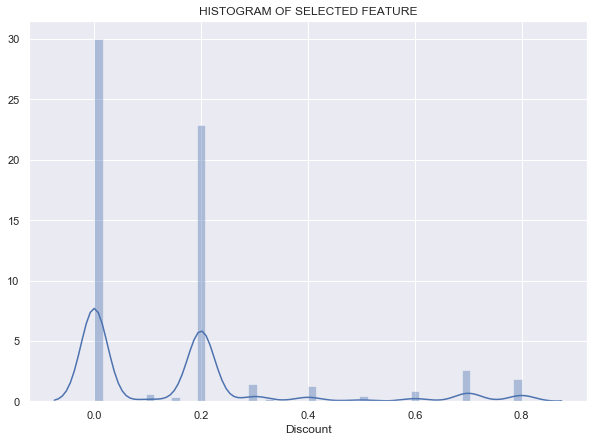

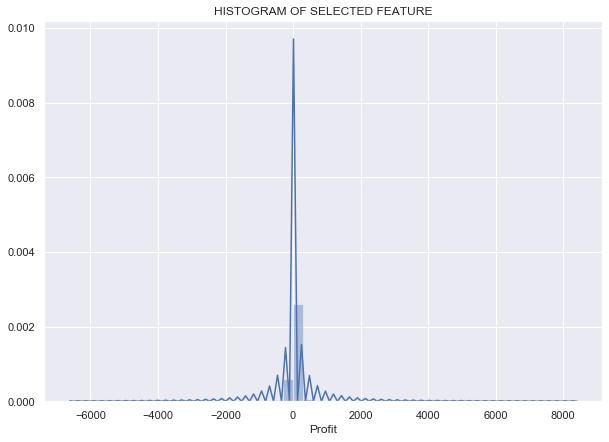

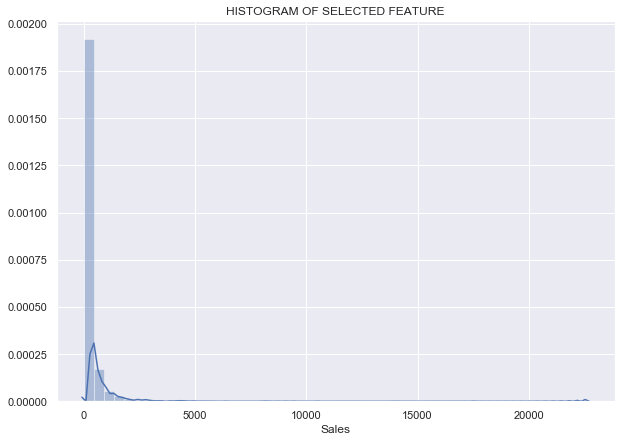

In [13]:
df = store_df
columns = ['Discount', 'Profit', 'Sales']
for col in columns:
    hist_plot(df, col)

### Wrangle the Data

In [14]:
# Change the dtype of 'Order Date' and 'Ship Date' to datetime
cols = ['Order Date','Ship Date']
store_df[cols] = store_df[cols].apply(pd.to_datetime)
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 1.6+ 

In [15]:
# establish the subset of data to use for further evaluation
data_df = store_df.copy(deep=False)
# these features are redundant or are well described by other existing features; remove them:
data_df = data_df.drop(['Row ID', 'Order ID', 'Customer Name', 'Country', 'State', 'City', 'Product Name'], axis=1)

In [16]:
# remove the customer initials from the 'Customer ID' attribute:
data_df['Customer ID'] = data_df['Customer ID'].str[3:]
# verify the count of 'Customer ID' unique values is consistent:
val1 = store_df['Customer ID'].unique()
val2 = data_df['Customer ID'].unique()
print('BEFORE:\nCustomer ID ({})'.format(len(val1)))
print('\nAFTER:\nCustomer ID ({})'.format(len(val2)))
# change the dtype of the 'Customer ID' attribute:
data_df = data_df.astype({'Customer ID':'int64'})

BEFORE:
Customer ID (793)

AFTER:
Customer ID (793)


### One-Hot-Encoding

In [17]:
col = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']
data_encoded = pd.get_dummies(data_df, columns=col, prefix=col)
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 40 columns):
Order Date                  9994 non-null datetime64[ns]
Ship Date                   9994 non-null datetime64[ns]
Customer ID                 9994 non-null int64
Postal Code                 9994 non-null int64
Product ID                  9994 non-null object
Sales                       9994 non-null float64
Quantity                    9994 non-null int64
Discount                    9994 non-null float64
Profit                      9994 non-null float64
Ship Mode_First Class       9994 non-null uint8
Ship Mode_Same Day          9994 non-null uint8
Ship Mode_Second Class      9994 non-null uint8
Ship Mode_Standard Class    9994 non-null uint8
Segment_Consumer            9994 non-null uint8
Segment_Corporate           9994 non-null uint8
Segment_Home Office         9994 non-null uint8
Region_Central              9994 non-null uint8
Region_East                 9994 non-null uint8
Regi

### Label Encoder

In [18]:
# return the unique sub-category designations existing within the 'Product ID' feature 
temp = pd.DataFrame(store_df['Product ID'].str[0:3])
sub_prod = temp['Product ID'].unique()
print('Product ID Codes:\n', sub_prod)
print('\nCategories:\n', store_df['Category'].unique())

Product ID Codes:
 ['FUR' 'OFF' 'TEC']

Categories:
 ['Furniture' 'Office Supplies' 'Technology']


In [19]:
# return the unique sub-category designations existing within the 'Product ID' feature 
temp = pd.DataFrame(store_df['Product ID'].str[4:6])
sub_prod = temp['Product ID'].unique()
print('Product ID Codes:\n', sub_prod)
print('\nSub-Categories:\n', store_df['Sub-Category'].unique())

Product ID Codes:
 ['BO' 'CH' 'LA' 'TA' 'ST' 'FU' 'AR' 'PH' 'BI' 'AP' 'PA' 'AC' 'EN' 'FA'
 'SU' 'MA' 'CO']

Sub-Categories:
 ['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [20]:
# encode the 'Product ID' with updated labels that currently are given as 'Category'-'Sub-Category'-'ID'
feature = 'Product ID'
for element in store_df[feature]:
    val_new = encode_feature(store_df, feature, element)
    data_encoded = data_encoded.replace({feature: {element:val_new}})

In [21]:
# data_encoded['Product ID _new'].unique()
_val = store_df['Product ID'].unique()
val = data_encoded['Product ID'].unique()
print('BEFORE:\nProduct ID ({})'.format(len(_val)))

print('\nAFTER:\nProduct ID ({})'.format(len(val)))

# change the dtype of the 'Customer ID' attribute:
data_encoded = data_encoded.astype({'Product ID':'float'})

BEFORE:
Product ID (1862)

AFTER:
Product ID (1862)


In [22]:
# return the 'Product ID' values via comparison in order to validate the encoded results
i = 0
while i < data_encoded.shape[0]:
    print('----------')
    print(store_df.iloc[i,13])
    print(int(data_encoded.iloc[i,5]))
    i += 1

----------
FUR-BO-10001798
261
----------
FUR-CH-10000454
731
----------
OFF-LA-10000240
14
----------
FUR-TA-10000577
957
----------
OFF-ST-10000760
22
----------
FUR-FU-10001487
48
----------
OFF-AR-10002833
7
----------
TEC-PH-10002275
907
----------
OFF-BI-10003910
18
----------
OFF-AP-10002892
114
----------
FUR-TA-10001539
1706
----------
TEC-PH-10002033
911
----------
OFF-PA-10002365
15
----------
OFF-BI-10003656
407
----------
OFF-AP-10002311
68
----------
OFF-BI-10000756
2
----------
OFF-ST-10004186
665
----------
OFF-ST-10000107
55
----------
OFF-AR-10003056
8
----------
TEC-PH-10001949
213
----------
OFF-BI-10002215
22
----------
OFF-AR-10000246
19
----------
OFF-AP-10001492
60
----------
FUR-CH-10002774
71
----------
FUR-TA-10000577
1044
----------
OFF-BI-10001634
11
----------
TEC-AC-10003027
90
----------
FUR-BO-10004834
3083
----------
OFF-BI-10000474
9
----------
FUR-FU-10004848
124
----------
OFF-EN-10001509
3
----------
OFF-AR-10004042
86
----------
OFF-BI-10001525
6


466
----------
FUR-FU-10001756
15
----------
OFF-LA-10000634
6
----------
FUR-FU-10001588
87
----------
TEC-PH-10002398
178
----------
OFF-PA-10001937
15
----------
OFF-AR-10003373
99
----------
FUR-CH-10002602
135
----------
TEC-MA-10002927
3991
----------
TEC-PH-10004093
275
----------
TEC-AC-10000892
360
----------
OFF-ST-10002974
43
----------
OFF-FA-10000624
7
----------
OFF-BI-10004593
251
----------
TEC-AC-10001908
99
----------
FUR-FU-10001967
15
----------
TEC-PH-10003645
290
----------
OFF-ST-10000675
54
----------
FUR-CH-10003312
786
----------
OFF-LA-10001074
100
----------
OFF-BI-10001524
37
----------
TEC-PH-10004614
82
----------
OFF-BI-10001153
20
----------
OFF-BI-10001982
4
----------
OFF-BI-10001922
4
----------
TEC-CO-10001449
959
----------
OFF-BI-10004140
14
----------
OFF-BI-10003314
7
----------
FUR-TA-10004575
698
----------
OFF-FA-10000490
4
----------
OFF-AR-10000122
17
----------
OFF-BI-10003656
509
----------
OFF-FA-10002780
30
----------
TEC-PH-10000702
71

447
----------
TEC-AC-10003911
159
----------
OFF-PA-10000289
12
----------
OFF-AP-10003040
134
----------
OFF-PA-10000350
17
----------
OFF-BI-10001759
6
----------
FUR-TA-10000577
1114
----------
OFF-PA-10004101
32
----------
OFF-ST-10001496
540
----------
OFF-BI-10002931
167
----------
FUR-TA-10002356
393
----------
FUR-FU-10003601
516
----------
FUR-FU-10000576
1007
----------
FUR-TA-10004154
2065
----------
OFF-PA-10000788
15
----------
OFF-PA-10002479
25
----------
FUR-FU-10001940
25
----------
OFF-AR-10001958
27
----------
FUR-BO-10004709
78
----------
OFF-ST-10000604
173
----------
TEC-PH-10002923
29
----------
OFF-BI-10004465
4
----------
OFF-PA-10002333
15
----------
FUR-FU-10004188
204
----------
FUR-CH-10002965
321
----------
OFF-BI-10000145
6
----------
OFF-EN-10001335
21
----------
OFF-LA-10001613
4
----------
OFF-LA-10004055
9
----------
OFF-AR-10004344
35
----------
OFF-PA-10004621
12
----------
OFF-PA-10001281
191
----------
OFF-LA-10001613
8
----------
OFF-ST-10001097

12
----------
OFF-ST-10000563
102
----------
OFF-AP-10004487
48
----------
OFF-BI-10002854
44
----------
OFF-PA-10004621
10
----------
FUR-CH-10001973
388
----------
OFF-PA-10004040
14
----------
TEC-AC-10000580
63
----------
OFF-AR-10004022
86
----------
TEC-AC-10004209
32
----------
TEC-AC-10000023
83
----------
TEC-PH-10003505
278
----------
OFF-LA-10000121
15
----------
OFF-BI-10002026
17
----------
OFF-PA-10000994
251
----------
OFF-BI-10002813
2
----------
OFF-ST-10000617
14
----------
OFF-AR-10004817
15
----------
FUR-FU-10000397
39
----------
OFF-BI-10000605
12
----------
OFF-AR-10001860
20
----------
OFF-BI-10004970
13
----------
OFF-PA-10003172
32
----------
OFF-SU-10001218
32
----------
OFF-PA-10002968
114
----------
OFF-LA-10000134
3
----------
OFF-AP-10004487
845
----------
OFF-BI-10002103
13
----------
OFF-BI-10004632
20
----------
TEC-PH-10003555
114
----------
OFF-ST-10001590
26
----------
FUR-FU-10003664
572
----------
FUR-FU-10003664
286
----------
FUR-BO-10003433
61


----------
OFF-AR-10001044
155
----------
TEC-PH-10004700
39
----------
OFF-AR-10000823
5
----------
OFF-AR-10004456
73
----------
OFF-BI-10000050
5
----------
OFF-PA-10002377
22
----------
OFF-BI-10000591
9
----------
FUR-BO-10000362
290
----------
TEC-PH-10000441
201
----------
TEC-PH-10002726
83
----------
OFF-ST-10003306
1000
----------
TEC-AC-10004855
83
----------
OFF-LA-10002787
3
----------
OFF-LA-10002043
41
----------
OFF-AR-10001915
29
----------
OFF-ST-10000352
59
----------
OFF-PA-10000575
6
----------
FUR-FU-10002937
198
----------
OFF-LA-10003930
786
----------
OFF-BI-10001107
23
----------
TEC-AC-10003063
50
----------
TEC-PH-10002922
675
----------
TEC-AC-10002049
1265
----------
OFF-AP-10002457
523
----------
FUR-CH-10001270
517
----------
FUR-FU-10004415
17
----------
OFF-BI-10001510
41
----------
OFF-ST-10002011
1006
----------
OFF-PA-10002986
10
----------
OFF-PA-10004451
10
----------
OFF-ST-10000649
25
----------
TEC-AC-10001465
58
----------
OFF-PA-10001166
15
-

259
----------
OFF-PA-10000357
221
----------
TEC-AC-10001266
26
----------
OFF-PA-10004888
15
----------
OFF-BI-10003460
0
----------
OFF-PA-10000157
19
----------
OFF-BI-10004519
398
----------
OFF-AR-10004272
5
----------
OFF-FA-10000585
17
----------
FUR-CH-10004218
323
----------
OFF-SU-10004231
29
----------
TEC-PH-10001578
1295
----------
OFF-ST-10003638
46
----------
FUR-BO-10002213
425
----------
FUR-TA-10001307
209
----------
OFF-PA-10002222
159
----------
OFF-PA-10002479
5
----------
OFF-BI-10003091
895
----------
OFF-BI-10000145
2
----------
FUR-CH-10003061
215
----------
FUR-BO-10001972
241
----------
OFF-LA-10000134
27
----------
OFF-EN-10003040
104
----------
TEC-PH-10000923
62
----------
TEC-AC-10000158
86
----------
FUR-FU-10003623
64
----------
OFF-PA-10001293
20
----------
OFF-AP-10000124
33
----------
OFF-AR-10004511
38
----------
FUR-FU-10000076
139
----------
OFF-PA-10003883
19
----------
OFF-BI-10003656
152
----------
OFF-FA-10000053
10
----------
TEC-PH-10002807

1349
----------
FUR-BO-10000362
136
----------
FUR-FU-10003878
61
----------
OFF-BI-10000591
1
----------
OFF-AR-10003727
16
----------
TEC-AC-10001635
24
----------
OFF-LA-10001317
2
----------
FUR-TA-10000577
1218
----------
OFF-LA-10000248
5
----------
OFF-PA-10000955
15
----------
FUR-FU-10000221
6
----------
FUR-CH-10002304
41
----------
FUR-CH-10004886
230
----------
OFF-BI-10001525
18
----------
OFF-LA-10003663
5
----------
OFF-BI-10001294
121
----------
OFF-AR-10000369
4
----------
TEC-PH-10001300
67
----------
OFF-ST-10000876
37
----------
OFF-LA-10001404
18
----------
OFF-PA-10001972
25
----------
TEC-CO-10004722
11199
----------
TEC-PH-10001494
2399
----------
OFF-EN-10002500
63
----------
TEC-PH-10003800
52
----------
TEC-AC-10002399
60
----------
TEC-MA-10002210
652
----------
OFF-BI-10003196
11
----------
OFF-PA-10000477
14
----------
FUR-FU-10000076
39
----------
FUR-CH-10002017
42
----------
FUR-CH-10004287
220
----------
FUR-FU-10003829
4
----------
OFF-BI-10004728
7
-

35
----------
OFF-BI-10001636
47
----------
OFF-PA-10001736
248
----------
OFF-PA-10000482
189
----------
OFF-BI-10001658
59
----------
FUR-CH-10000422
90
----------
FUR-CH-10004675
1526
----------
FUR-CH-10002880
368
----------
OFF-ST-10000675
305
----------
FUR-FU-10002685
18
----------
FUR-FU-10004020
38
----------
FUR-FU-10004963
26
----------
OFF-BI-10000174
64
----------
OFF-EN-10000461
43
----------
TEC-AC-10001266
41
----------
OFF-PA-10002160
23
----------
FUR-CH-10004875
113
----------
FUR-FU-10000305
113
----------
TEC-PH-10000347
7
----------
TEC-PH-10001459
671
----------
TEC-PH-10000439
39
----------
FUR-CH-10002647
191
----------
OFF-BI-10003910
2
----------
OFF-BI-10001097
19
----------
OFF-FA-10004854
45
----------
OFF-PA-10003673
20
----------
OFF-LA-10002034
39
----------
FUR-CH-10002774
81
----------
FUR-CH-10003817
97
----------
OFF-BI-10002949
24
----------
FUR-FU-10002445
18
----------
FUR-FU-10001473
32
----------
OFF-ST-10002562
30
----------
OFF-AP-10002118
49

----------
TEC-AC-10003709
2
----------
OFF-FA-10000304
6
----------
TEC-AC-10003709
7
----------
FUR-CH-10002774
203
----------
TEC-CO-10001046
3359
----------
OFF-FA-10003495
18
----------
OFF-AR-10004685
27
----------
OFF-AR-10004757
22
----------
TEC-PH-10001615
28
----------
OFF-PA-10003349
12
----------
OFF-AR-10000127
22
----------
OFF-SU-10002881
4164
----------
TEC-AC-10001109
47
----------
OFF-PA-10000682
4
----------
FUR-FU-10000221
15
----------
OFF-BI-10002429
63
----------
OFF-AR-10002375
6
----------
OFF-AP-10000595
13
----------
TEC-PH-10001530
494
----------
OFF-BI-10000050
29
----------
TEC-AC-10001552
248
----------
TEC-AC-10003399
36
----------
OFF-AR-10004078
11
----------
OFF-SU-10002189
11
----------
FUR-FU-10001852
3
----------
OFF-BI-10003638
30
----------
TEC-MA-10002428
1704
----------
OFF-BI-10001036
19
----------
OFF-AP-10004708
121
----------
TEC-MA-10000488
1919
----------
OFF-BI-10003656
50
----------
OFF-ST-10003656
76
----------
TEC-PH-10001128
539
---

----------
FUR-CH-10004997
657
----------
OFF-PA-10000357
277
----------
FUR-FU-10003976
25
----------
FUR-FU-10004960
91
----------
OFF-EN-10001099
29
----------
OFF-BI-10002026
139
----------
OFF-LA-10001613
6
----------
OFF-ST-10002214
27
----------
OFF-ST-10001128
177
----------
TEC-AC-10004864
58
----------
OFF-PA-10000174
16
----------
TEC-AC-10000171
36
----------
FUR-TA-10002622
718
----------
OFF-AR-10001915
31
----------
OFF-BI-10004410
9
----------
OFF-BI-10004632
487
----------
TEC-PH-10002185
5
----------
OFF-ST-10002974
217
----------
OFF-AR-10003727
40
----------
TEC-PH-10004071
63
----------
FUR-FU-10002878
142
----------
OFF-BI-10001890
7
----------
FUR-CH-10002647
681
----------
OFF-AR-10001315
3
----------
OFF-AR-10000122
5
----------
TEC-AC-10001465
36
----------
OFF-BI-10004600
2060
----------
OFF-AP-10002082
52
----------
OFF-AP-10004708
213
----------
OFF-ST-10000464
69
----------
OFF-ST-10000025
763
----------
OFF-LA-10001613
9
----------
TEC-PH-10000376
41
----

----------
OFF-AP-10002350
56
----------
FUR-FU-10003096
22
----------
FUR-CH-10003061
287
----------
TEC-CO-10003763
2799
----------
OFF-PA-10002923
48
----------
FUR-BO-10003441
257
----------
OFF-ST-10001780
2591
----------
OFF-AP-10001962
41
----------
FUR-FU-10003798
79
----------
FUR-FU-10001095
52
----------
OFF-SU-10000157
286
----------
FUR-FU-10001095
63
----------
OFF-SU-10004261
41
----------
OFF-AR-10004022
172
----------
FUR-BO-10002916
512
----------
FUR-CH-10002084
860
----------
TEC-PH-10003012
769
----------
OFF-AR-10002704
14
----------
FUR-FU-10000308
373
----------
FUR-BO-10004709
231
----------
FUR-FU-10001196
63
----------
TEC-AC-10002942
345
----------
FUR-TA-10004915
637
----------
TEC-MA-10001016
287
----------
OFF-EN-10000483
36
----------
OFF-AR-10003087
1
----------
OFF-PA-10000520
25
----------
TEC-AC-10001553
101
----------
OFF-AR-10000634
6
----------
FUR-FU-10001215
474
----------
OFF-PA-10001204
8
----------
OFF-ST-10002444
39
----------
OFF-AR-1000020

----------
OFF-BI-10000014
2
----------
OFF-AR-10003217
27
----------
OFF-AP-10002403
26
----------
OFF-PA-10001972
10
----------
OFF-PA-10004041
23
----------
TEC-AC-10004975
109
----------
OFF-ST-10001932
965
----------
OFF-AR-10001761
29
----------
OFF-PA-10002262
32
----------
OFF-EN-10004483
78
----------
OFF-PA-10003270
31
----------
OFF-BI-10001634
29
----------
OFF-ST-10000675
169
----------
FUR-FU-10000732
12
----------
OFF-PA-10004355
6
----------
OFF-EN-10000056
186
----------
FUR-FU-10000221
25
----------
OFF-EN-10003567
43
----------
FUR-BO-10001811
1279
----------
OFF-ST-10002486
27
----------
FUR-CH-10002372
129
----------
OFF-BI-10003274
6
----------
OFF-PA-10001878
244
----------
OFF-SU-10002881
1332
----------
FUR-FU-10001979
32
----------
OFF-ST-10001522
147
----------
TEC-AC-10003657
54
----------
OFF-BI-10001718
76
----------
OFF-PA-10003022
14
----------
OFF-AP-10000891
209
----------
OFF-BI-10004970
3
----------
OFF-AR-10003759
16
----------
OFF-EN-10003001
167
-

OFF-PA-10004733
25
----------
OFF-BI-10003355
11
----------
OFF-SU-10001212
6
----------
TEC-PH-10000486
742
----------
FUR-FU-10004909
6
----------
OFF-LA-10001613
11
----------
TEC-PH-10004447
222
----------
OFF-AR-10000255
23
----------
OFF-LA-10004425
8
----------
OFF-SU-10001664
25
----------
OFF-AP-10000696
100
----------
FUR-CH-10002647
63
----------
FUR-CH-10002758
683
----------
OFF-BI-10000201
1
----------
OFF-SU-10004115
40
----------
OFF-PA-10000806
279
----------
OFF-AR-10001473
13
----------
FUR-BO-10003450
69
----------
OFF-AR-10001545
4
----------
TEC-AC-10004396
58
----------
FUR-FU-10002456
52
----------
FUR-FU-10001473
54
----------
FUR-TA-10000849
364
----------
OFF-PA-10001166
85
----------
OFF-PA-10003256
27
----------
OFF-PA-10002870
24
----------
FUR-FU-10001215
43
----------
OFF-BI-10004187
5
----------
OFF-BI-10001718
57
----------
OFF-PA-10004983
31
----------
FUR-FU-10002396
30
----------
TEC-PH-10003988
43
----------
OFF-AR-10002467
4
----------
OFF-BI-1000

----------
TEC-MA-10003173
52
----------
FUR-FU-10000260
32
----------
OFF-AP-10004487
406
----------
FUR-FU-10001487
27
----------
FUR-TA-10001520
399
----------
OFF-BI-10000145
3
----------
FUR-CH-10000595
715
----------
TEC-AC-10004469
159
----------
TEC-AC-10003038
44
----------
FUR-CH-10004698
340
----------
OFF-PA-10003641
105
----------
TEC-AC-10002134
13
----------
OFF-ST-10001837
85
----------
FUR-FU-10001706
6
----------
OFF-PA-10001970
36
----------
OFF-ST-10002957
15
----------
OFF-LA-10002312
44
----------
OFF-EN-10002600
21
----------
OFF-BI-10003274
9
----------
FUR-BO-10004467
89
----------
OFF-PA-10000675
163
----------
OFF-PA-10002259
17
----------
FUR-CH-10004287
966
----------
OFF-PA-10000482
182
----------
OFF-ST-10004835
4
----------
FUR-TA-10004086
51
----------
OFF-LA-10000305
50
----------
OFF-PA-10000806
89
----------
FUR-FU-10004018
14
----------
TEC-PH-10002660
543
----------
OFF-EN-10001509
4
----------
OFF-LA-10003148
18
----------
FUR-TA-10002645
2275
---

----------
OFF-LA-10001641
3
----------
OFF-PA-10002377
22
----------
FUR-FU-10000010
14
----------
OFF-AP-10002651
1158
----------
TEC-CO-10002313
599
----------
OFF-ST-10001580
23
----------
FUR-CH-10001545
638
----------
OFF-BI-10004826
13
----------
OFF-BI-10000301
15
----------
OFF-PA-10000994
104
----------
OFF-AR-10003156
30
----------
FUR-CH-10000988
112
----------
TEC-MA-10003329
71
----------
OFF-AR-10001547
2
----------
OFF-EN-10003072
15
----------
OFF-PA-10000726
36
----------
FUR-BO-10001972
217
----------
OFF-SU-10004664
39
----------
OFF-BI-10003676
22
----------
OFF-AR-10003727
95
----------
FUR-FU-10003829
12
----------
OFF-BI-10003712
4
----------
OFF-FA-10002280
35
----------
FUR-CH-10002961
72
----------
OFF-AP-10002578
97
----------
FUR-FU-10004848
51
----------
OFF-BI-10003364
46
----------
OFF-ST-10002615
1395
----------
FUR-FU-10000521
117
----------
OFF-LA-10000121
18
----------
OFF-PA-10001289
77
----------
FUR-CH-10004495
421
----------
TEC-PH-10000895
575
-

311
----------
OFF-BI-10000829
22
----------
TEC-PH-10001448
39
----------
FUR-CH-10004983
1159
----------
OFF-AR-10004022
179
----------
TEC-AC-10001284
116
----------
FUR-FU-10001847
12
----------
TEC-AC-10004595
428
----------
FUR-FU-10004164
24
----------
OFF-LA-10001074
87
----------
OFF-ST-10000604
69
----------
TEC-PH-10000148
20
----------
OFF-BI-10000042
12
----------
OFF-LA-10000443
5
----------
FUR-FU-10002874
63
----------
OFF-ST-10003994
141
----------
OFF-EN-10001453
304
----------
FUR-CH-10000988
563
----------
FUR-TA-10003238
661
----------
TEC-PH-10001061
239
----------
FUR-TA-10003715
502
----------
OFF-BI-10001597
196
----------
FUR-CH-10004063
915
----------
FUR-FU-10001979
327
----------
FUR-CH-10001854
701
----------
TEC-PH-10002923
88
----------
OFF-AR-10004691
64
----------
OFF-BI-10002931
33
----------
OFF-AP-10002651
1737
----------
OFF-ST-10000689
704
----------
OFF-PA-10003302
141
----------
OFF-BI-10001460
36
----------
FUR-FU-10003489
25
----------
OFF-BI-

14
----------
OFF-BI-10002854
196
----------
OFF-AR-10002445
35
----------
OFF-PA-10004359
419
----------
OFF-BI-10000279
13
----------
OFF-BI-10003314
7
----------
OFF-BI-10000494
4
----------
OFF-PA-10000295
38
----------
OFF-PA-10002615
17
----------
OFF-ST-10003479
93
----------
TEC-AC-10002800
449
----------
FUR-BO-10003159
344
----------
FUR-FU-10002364
14
----------
OFF-BI-10003350
12
----------
OFF-LA-10004093
58
----------
FUR-FU-10000732
20
----------
OFF-SU-10004884
37
----------
FUR-TA-10001771
138
----------
OFF-ST-10000060
259
----------
OFF-PA-10004100
20
----------
FUR-FU-10003975
129
----------
OFF-PA-10001712
69
----------
OFF-AR-10001953
140
----------
OFF-BI-10004967
8
----------
FUR-FU-10003731
9
----------
OFF-BI-10001989
62
----------
OFF-ST-10000344
21
----------
TEC-PH-10001051
239
----------
FUR-FU-10001215
34
----------
FUR-FU-10001473
20
----------
OFF-BI-10000315
3
----------
FUR-FU-10002240
7
----------
FUR-TA-10002607
35
----------
TEC-MA-10003356
269
---

----------
OFF-BI-10000605
9
----------
OFF-BI-10003314
23
----------
OFF-AR-10002067
99
----------
OFF-BI-10001031
21
----------
FUR-FU-10003832
46
----------
OFF-BI-10000138
18
----------
FUR-TA-10004607
236
----------
OFF-LA-10003148
18
----------
OFF-PA-10001804
10
----------
OFF-ST-10000036
237
----------
OFF-PA-10001166
5
----------
OFF-PA-10001033
65
----------
FUR-FU-10004597
22
----------
OFF-PA-10000418
419
----------
FUR-FU-10004090
88
----------
OFF-AR-10000390
9
----------
FUR-CH-10003774
318
----------
OFF-BI-10002412
5
----------
TEC-PH-10002415
1415
----------
TEC-PH-10003505
148
----------
OFF-LA-10003663
9
----------
OFF-ST-10001780
1036
----------
TEC-PH-10002033
569
----------
OFF-BI-10001036
9
----------
FUR-FU-10001468
1196
----------
FUR-BO-10001519
523
----------
TEC-CO-10001943
639
----------
OFF-PA-10003127
52
----------
TEC-AC-10002076
538
----------
OFF-AR-10003338
14
----------
OFF-PA-10004610
34
----------
OFF-ST-10001272
261
----------
OFF-AP-10001366
87


----------
FUR-CH-10004063
915
----------
OFF-PA-10004610
8
----------
OFF-PA-10001878
97
----------
OFF-PA-10002036
31
----------
OFF-AP-10003278
11
----------
OFF-LA-10001641
5
----------
FUR-FU-10003806
242
----------
FUR-TA-10003392
337
----------
OFF-AR-10003856
13
----------
TEC-AC-10002006
76
----------
TEC-AC-10002006
102
----------
OFF-PA-10002246
10
----------
OFF-SU-10004782
47
----------
FUR-FU-10004351
23
----------
FUR-FU-10004270
16
----------
FUR-FU-10004053
16
----------
OFF-PA-10000019
32
----------
OFF-AR-10003811
19
----------
TEC-AC-10001838
399
----------
FUR-FU-10003553
343
----------
OFF-PA-10003302
106
----------
OFF-BI-10002412
13
----------
OFF-BI-10002852
82
----------
OFF-BI-10000145
6
----------
OFF-PA-10001970
447
----------
OFF-AP-10001563
272
----------
OFF-BI-10001359
1614
----------
OFF-FA-10003495
24
----------
TEC-AC-10003709
1
----------
FUR-FU-10003268
31
----------
OFF-EN-10003845
14
----------
FUR-CH-10002073
423
----------
OFF-PA-10001357
76
--

----------
FUR-TA-10003469
69
----------
OFF-SU-10004231
31
----------
TEC-PH-10002584
2003
----------
OFF-AR-10003602
9
----------
FUR-CH-10002331
2563
----------
FUR-CH-10001802
387
----------
OFF-AR-10000634
3
----------
OFF-ST-10002615
1085
----------
OFF-PA-10004040
43
----------
OFF-BI-10003727
3
----------
OFF-BI-10002026
34
----------
OFF-ST-10001496
432
----------
OFF-ST-10003716
675
----------
OFF-EN-10002504
65
----------
FUR-CH-10001270
207
----------
TEC-MA-10004241
600
----------
OFF-AR-10001468
59
----------
TEC-AC-10003198
637
----------
FUR-FU-10003039
51
----------
OFF-PA-10000295
31
----------
OFF-AR-10004344
47
----------
TEC-AC-10002473
158
----------
OFF-AP-10002403
211
----------
OFF-SU-10000432
5
----------
OFF-LA-10000443
2
----------
OFF-BI-10003166
10
----------
OFF-BI-10002393
18
----------
TEC-PH-10001809
299
----------
OFF-EN-10002600
26
----------
TEC-AC-10000109
111
----------
FUR-FU-10003829
4
----------
OFF-LA-10003223
11
----------
OFF-AR-10001770
7
-

24
----------
OFF-BI-10002194
7
----------
TEC-AC-10000892
288
----------
TEC-PH-10001870
146
----------
FUR-CH-10002304
83
----------
OFF-AP-10002534
942
----------
OFF-PA-10001125
74
----------
OFF-AP-10000804
26
----------
OFF-BI-10002982
10
----------
OFF-AR-10001547
3
----------
FUR-CH-10000665
528
----------
OFF-PA-10000520
41
----------
FUR-BO-10004015
287
----------
OFF-ST-10004258
29
----------
OFF-AR-10003696
55
----------
FUR-BO-10001811
1227
----------
OFF-BI-10001249
20
----------
FUR-TA-10003473
1128
----------
OFF-LA-10003190
4
----------
TEC-PH-10001305
195
----------
OFF-PA-10001534
15
----------
TEC-AC-10000844
271
----------
FUR-CH-10000847
698
----------
FUR-BO-10000468
77
----------
OFF-BI-10002799
46
----------
TEC-PH-10001557
537
----------
OFF-LA-10001934
14
----------
OFF-FA-10004248
22
----------
TEC-PH-10001944
583
----------
TEC-PH-10002085
211
----------
OFF-PA-10003441
12
----------
OFF-AR-10004602
45
----------
TEC-PH-10002555
1294
----------
TEC-CO-10001

14
----------
FUR-CH-10001545
102
----------
OFF-PA-10002947
20
----------
OFF-BI-10003476
32
----------
OFF-BI-10001359
4305
----------
FUR-FU-10000320
10
----------
TEC-PH-10001835
631
----------
OFF-BI-10003650
1577
----------
OFF-AR-10000937
255
----------
OFF-ST-10000532
184
----------
TEC-AC-10001267
47
----------
OFF-LA-10004853
15
----------
OFF-BI-10001759
8
----------
FUR-CH-10003379
398
----------
FUR-BO-10002853
163
----------
OFF-AP-10000027
67
----------
OFF-PA-10002421
72
----------
OFF-LA-10002475
11
----------
FUR-CH-10001482
392
----------
FUR-FU-10000087
18
----------
OFF-BI-10003166
6
----------
FUR-TA-10000688
457
----------
FUR-CH-10003981
1079
----------
OFF-PA-10001878
48
----------
OFF-AR-10002375
9
----------
OFF-BI-10004965
34
----------
OFF-BI-10004022
0
----------
OFF-BI-10000050
43
----------
OFF-PA-10002464
13
----------
FUR-BO-10004709
115
----------
TEC-AC-10003590
41
----------
TEC-PH-10003357
244
----------
OFF-AR-10003373
74
----------
OFF-BI-1000367

OFF-PA-10002137
7
----------
OFF-BI-10000088
54
----------
OFF-PA-10000380
50
----------
FUR-BO-10001619
339
----------
OFF-PA-10001609
10
----------
OFF-AP-10002765
42
----------
OFF-PA-10000167
123
----------
TEC-PH-10004434
135
----------
OFF-BI-10004995
2177
----------
FUR-FU-10004666
17
----------
OFF-BI-10001524
16
----------
TEC-AC-10002076
431
----------
OFF-BI-10001679
8
----------
OFF-AP-10003281
4
----------
TEC-PH-10001944
437
----------
OFF-BI-10004390
673
----------
OFF-PA-10002120
274
----------
OFF-ST-10004340
62
----------
FUR-FU-10001847
8
----------
OFF-BI-10000962
48
----------
FUR-CH-10004754
149
----------
FUR-BO-10001811
1023
----------
FUR-CH-10004063
600
----------
TEC-AC-10004901
39
----------
FUR-CH-10001714
211
----------
OFF-EN-10003134
56
----------
FUR-CH-10003396
107
----------
OFF-PA-10001560
4
----------
OFF-BI-10000977
18
----------
OFF-BI-10003429
3
----------
OFF-AR-10001374
10
----------
TEC-PH-10004977
235
----------
TEC-PH-10000912
26
----------


In [23]:
# verify the features are numeric, as req'd for model development
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 40 columns):
Order Date                  9994 non-null datetime64[ns]
Ship Date                   9994 non-null datetime64[ns]
Customer ID                 9994 non-null int64
Postal Code                 9994 non-null int64
Product ID                  9994 non-null float64
Sales                       9994 non-null float64
Quantity                    9994 non-null int64
Discount                    9994 non-null float64
Profit                      9994 non-null float64
Ship Mode_First Class       9994 non-null uint8
Ship Mode_Same Day          9994 non-null uint8
Ship Mode_Second Class      9994 non-null uint8
Ship Mode_Standard Class    9994 non-null uint8
Segment_Consumer            9994 non-null uint8
Segment_Corporate           9994 non-null uint8
Segment_Home Office         9994 non-null uint8
Region_Central              9994 non-null uint8
Region_East                 9994 non-null uint8
Reg

### Scale the Dataset

In [24]:
# make a copy of the encoded dataframe
data_scaled = data_encoded.copy()

# drop the specified features for scaling of those that remain
# NOTE: most of these dropped features contain '0' values
obsolete = ['Order Date', 'Ship Date',
            'Ship Mode_First Class', 'Ship Mode_Same Day', 'Ship Mode_Second Class', 'Ship Mode_Standard Class',
            'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office',
            'Region_Central', 'Region_East', 'Region_South', 'Region_West',
            'Category_Furniture', 'Category_Office Supplies', 'Category_Technology',
            'Sub-Category_Accessories', 'Sub-Category_Appliances', 'Sub-Category_Art', 'Sub-Category_Binders',
            'Sub-Category_Bookcases', 'Sub-Category_Chairs', 'Sub-Category_Copiers', 'Sub-Category_Envelopes',
            'Sub-Category_Fasteners', 'Sub-Category_Furnishings', 'Sub-Category_Labels', 'Sub-Category_Machines',
            'Sub-Category_Paper', 'Sub-Category_Phones', 'Sub-Category_Storage', 'Sub-Category_Supplies', 'Sub-Category_Tables']
# features = list(features_all)
features = list(data_encoded.columns)
for x in obsolete:
    features.remove(x)

# scale the remaining features
for feature in features:
    data_scaled[feature] = scale(data_scaled[feature])

In [25]:
data_scaled.head()

,Order Date,Ship Date,Customer ID,Postal Code,Product ID,Sales,Quantity,Discount,Profit,Ship Mode_First Class,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,2016-11-08,2016-11-11,-1.025941,-0.398302,-1.603632,0.051510,-0.804303,-0.756643,0.056593,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-11-08,2016-11-11,-1.025941,-0.398302,-1.588272,0.805633,-0.354865,-0.756643,0.815054,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-06-12,2016-06-16,-0.872821,1.086817,-0.036928,-0.345368,-0.804303,-0.756643,-0.093002,0,...,0,0,0,1,0,0,0,0,0,0
3,2015-10-11,2015-10-18,1.253352,-0.682407,-1.557552,1.167688,0.544012,1.423149,-1.757484,0,...,0,0,0,0,0,0,0,0,0,1
4,2015-10-11,2015-10-18,1.253352,-0.682407,-0.006208,-0.332935,-0.804303,0.212153,-0.111593,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
# show the scaled dataframe values
print('THE UNIQUE VALUES OF ALL DATASET FEATURES')
print('=========================================')
for feature in features:
    val = data_scaled[feature].unique()
    print('\n' + feature + ' ({}):\n   {}'.format(len(val), val))

THE UNIQUE VALUES OF ALL DATASET FEATURES

Customer ID (793):
   [-1.02594072 -0.87282125  1.25335195 -1.26218218 -1.62091922 -0.28221758
 -0.35658989  0.88586523 -1.68216701  1.7170852   0.15964146  1.1746048
 -0.63220494 -0.61033073  1.59896447  0.44400619 -0.45283642  1.362723
  0.26026282  1.12210669 -0.57095715  0.78086902  0.82461744  0.25151314
 -0.88594577 -0.22534463  1.46334437  0.19901504  0.85524133 -1.29718092
  0.06776978 -0.30846663 -0.08534969  0.1640163   1.38022237 -0.68470304
  0.01964652 -1.06093945  0.83336712 -0.4615861  -0.10284906  0.0808943
  1.06960859  0.79836839  0.08964399 -0.63657978  0.99961112 -0.45721126
  0.24276346 -0.22971948  0.88149038 -0.94281872 -1.01281619  1.1439809
 -0.85969672 -0.40471316  1.36709784 -1.70841606  0.91211428  1.62521352
  0.27338735 -0.71532694  0.2471383  -0.04160127  1.14835575  1.17897964
 -0.325966    0.47900492  0.03714588  1.45459468  1.34522363  0.71524639
 -0.8684464   0.76774449  1.46771921 -0.60595589  1.12648154  0.

### Explore the Data - II  
> Statistics, Visualizations

In [27]:
data_scaled.describe()

,Customer ID,Postal Code,Product ID,Sales,Quantity,Discount,Profit,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
count,9.994000e+03,9.994000e+03,9.994000e+03,9.994000e+03,9.994000e+03,9.994000e+03,9.994000e+03,9994.000000,9994.000000,9994.000000,...,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,9.320363e-17,-2.659470e-16,5.162720e-17,7.198189e-15,2.587262e-16,-4.732701e-14,-5.160943e-16,0.153892,0.054333,0.194617,...,0.025415,0.021713,0.095757,0.036422,0.011507,0.137082,0.088953,0.084651,0.019011,0.031919
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.360864,0.226684,0.395925,...,0.157391,0.145752,0.294273,0.187347,0.106657,0.343951,0.284691,0.278375,0.136572,0.175794
min,-1.756539e+00,-1.688922e+00,-1.603632e+00,-3.681144e-01,-1.253742e+00,-7.566435e-01,-2.829746e+01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.728212e-01,-9.970461e-01,-6.207935e-03,-3.410996e-01,-8.043034e-01,-7.566435e-01,-1.149555e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.402136e-02,3.867872e-02,5.523189e-02,-2.813929e-01,-3.548649e-01,2.121533e-01,-8.533846e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.596162e-01,1.085944e+00,1.166709e-01,-3.196013e-02,5.440122e-01,2.121533e-01,3.018606e-03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.717085e+00,1.375787e+00,1.714096e+00,3.595655e+01,4.588959e+00,3.118544e+00,3.573693e+01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


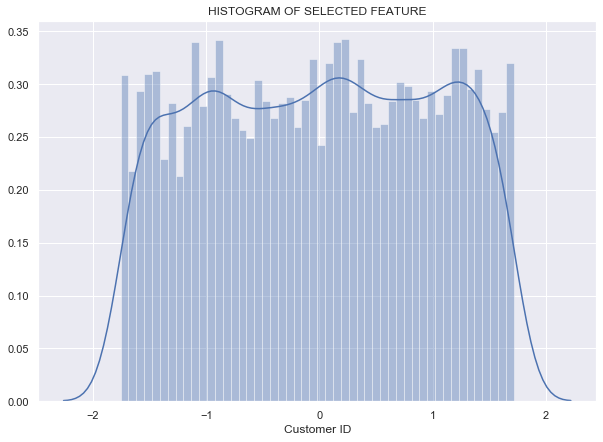

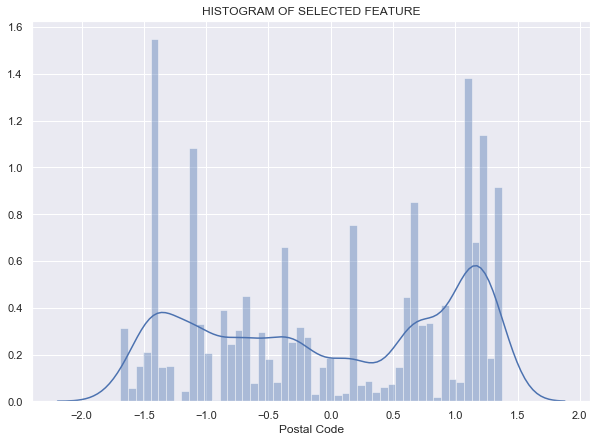

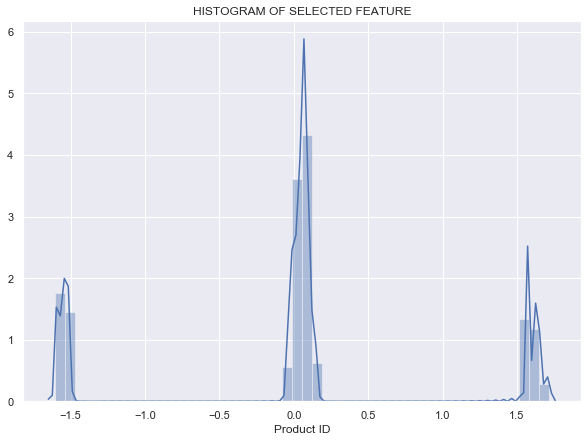

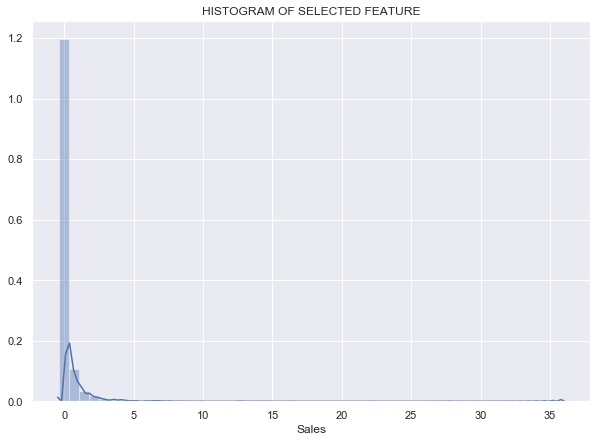

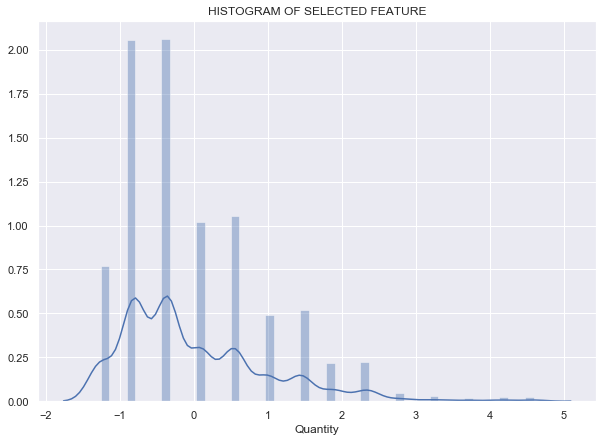

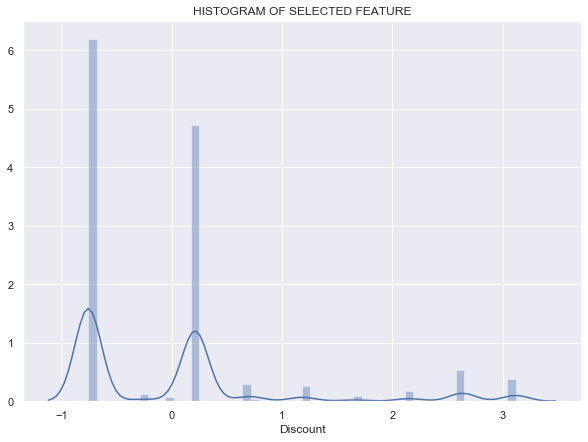

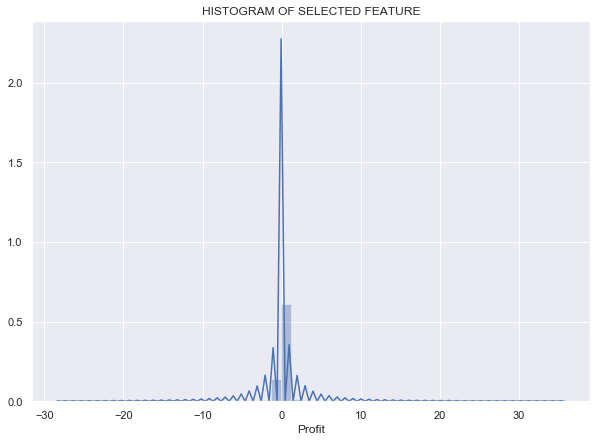

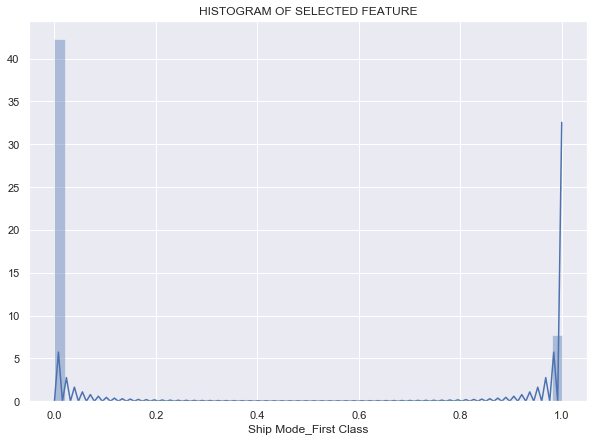

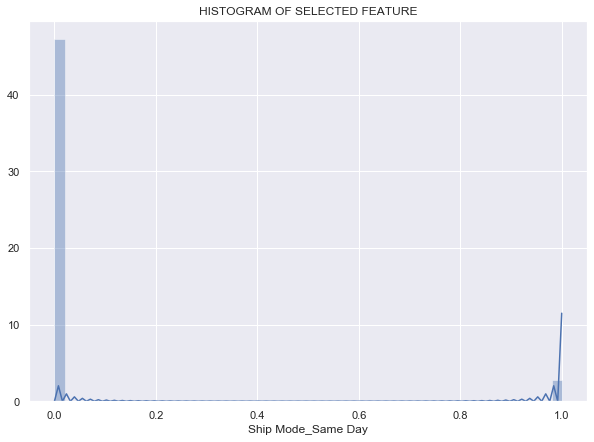

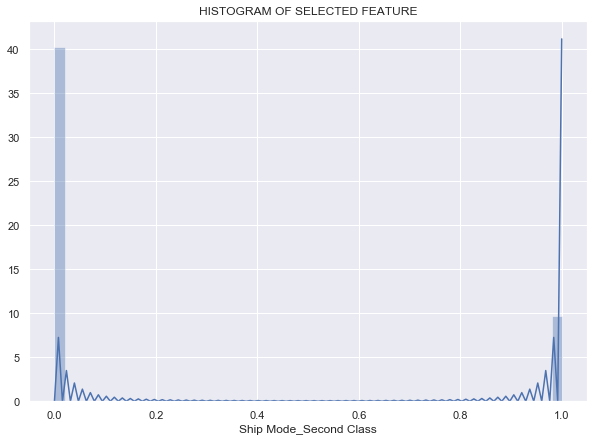

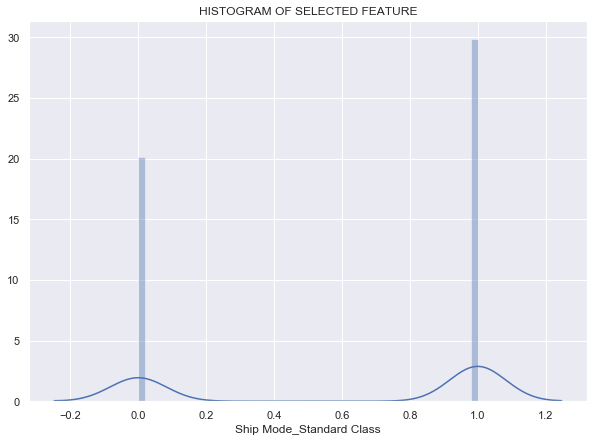

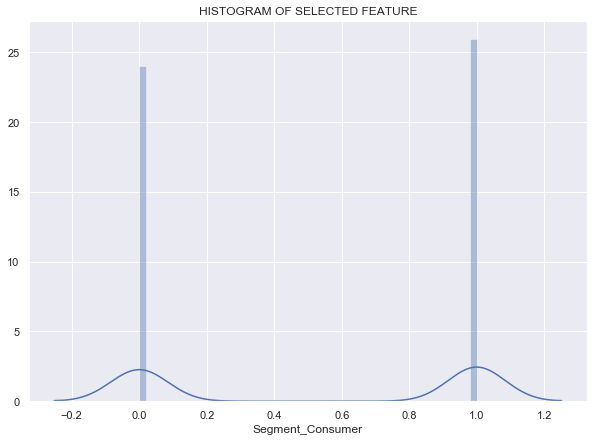

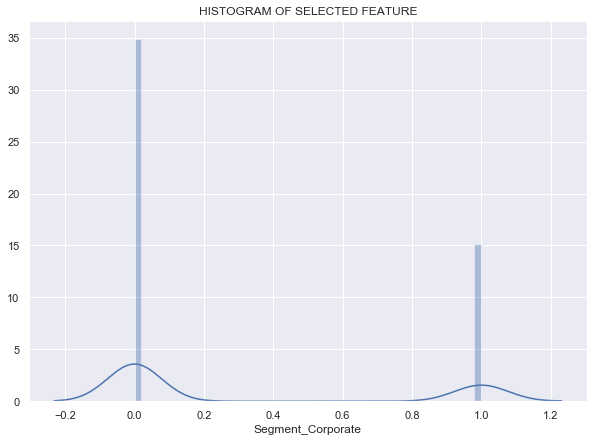

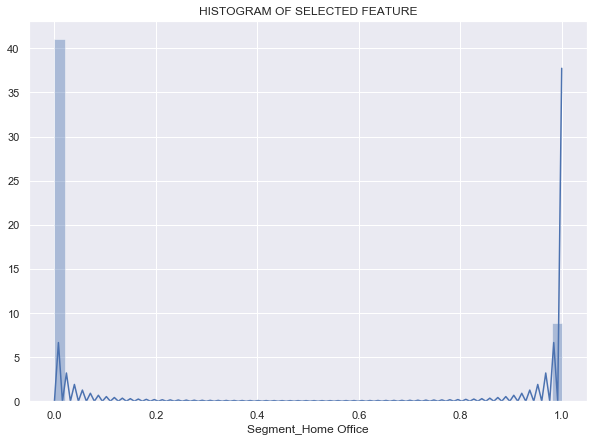

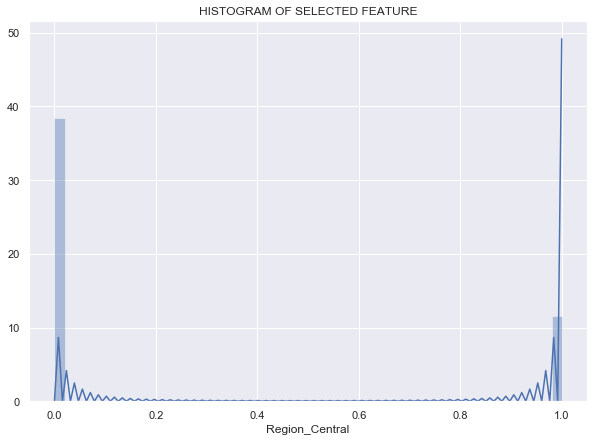

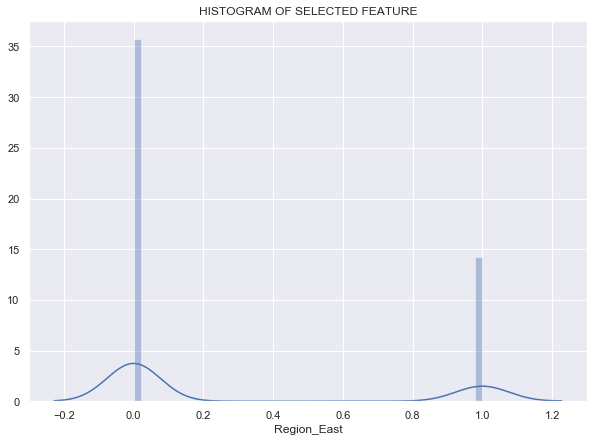

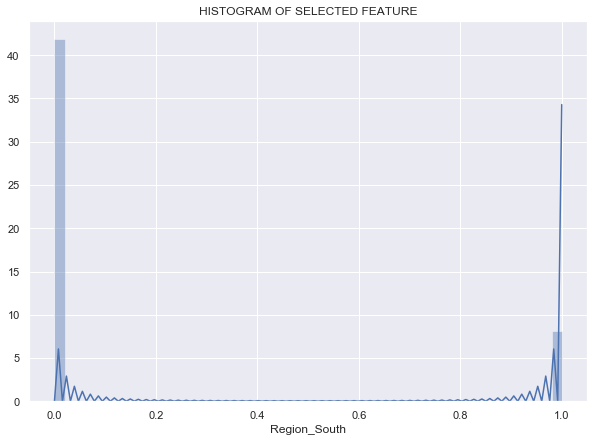

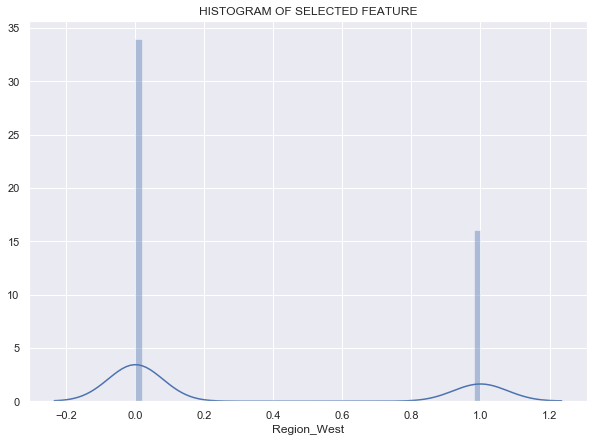

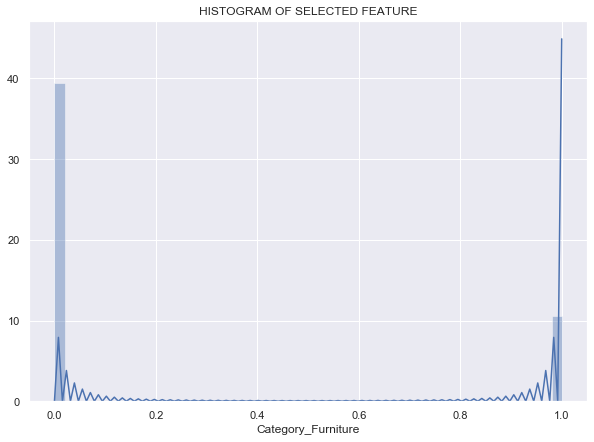

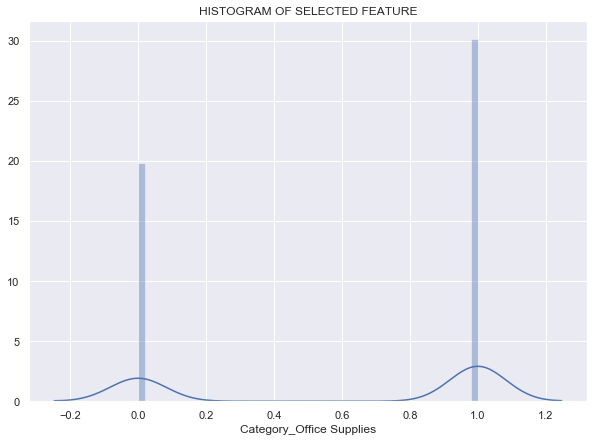

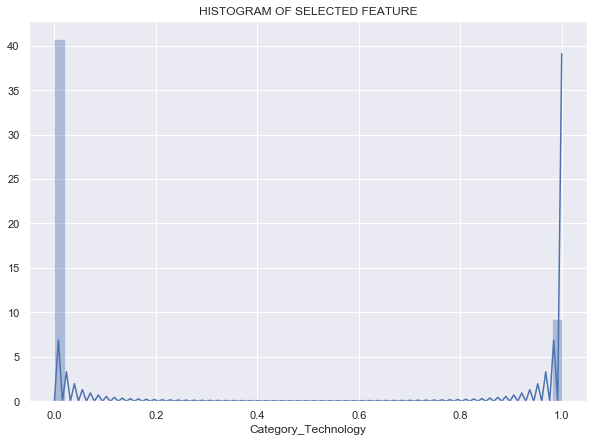

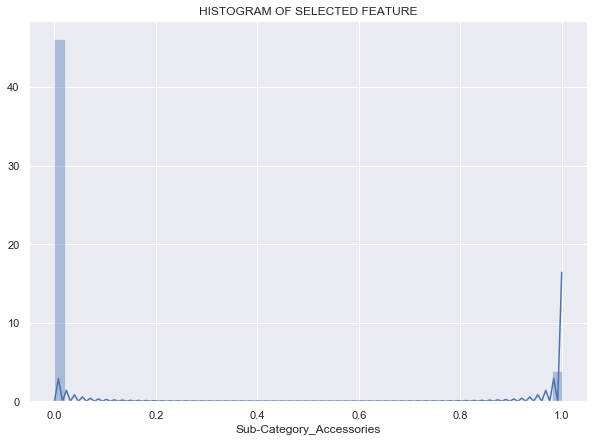

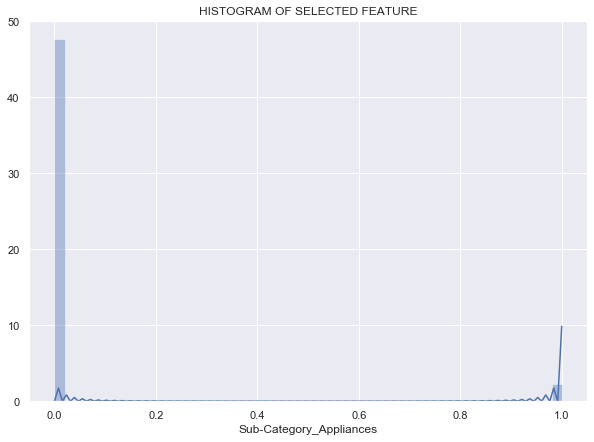

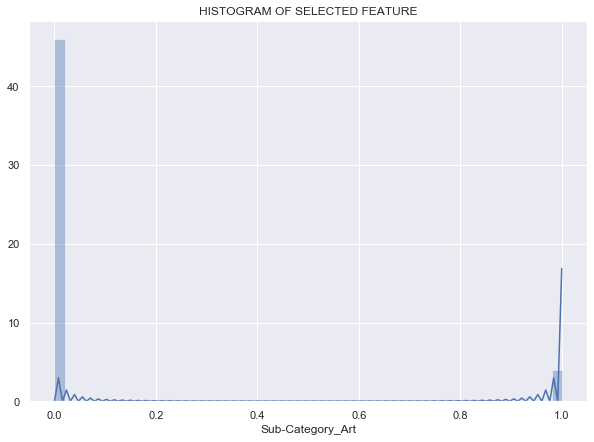

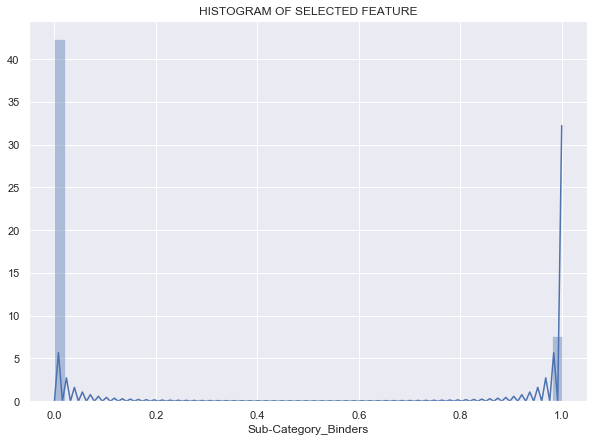

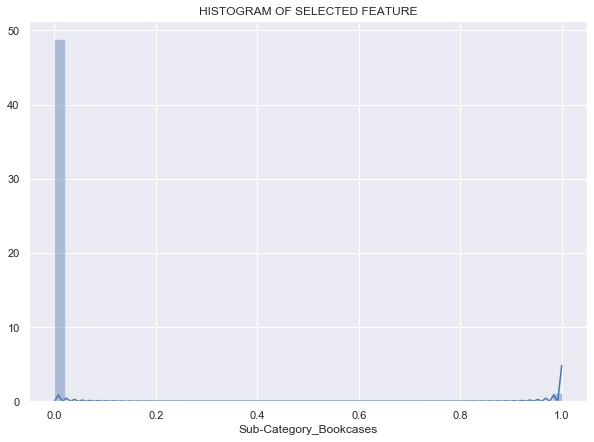

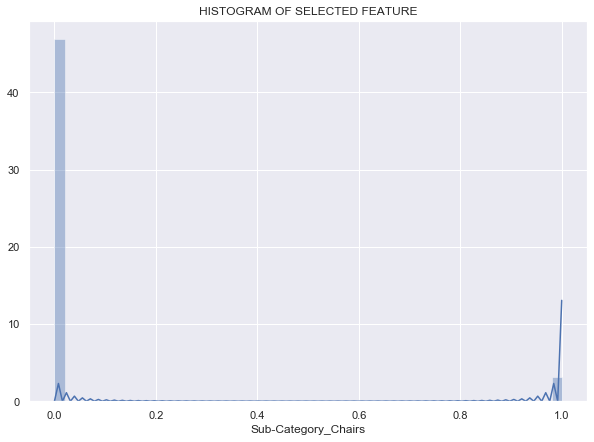

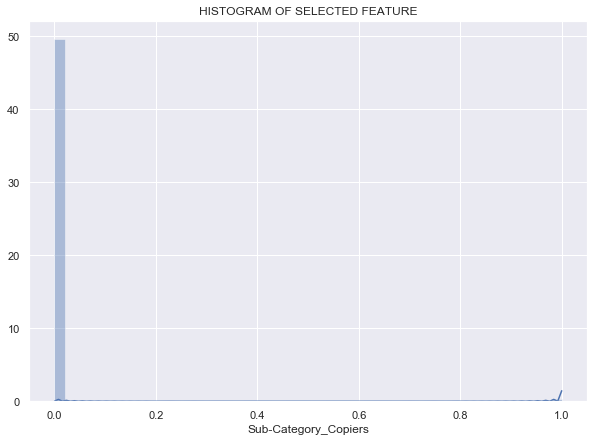

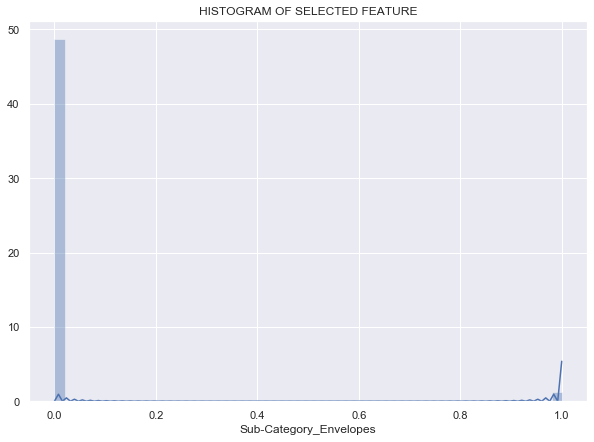

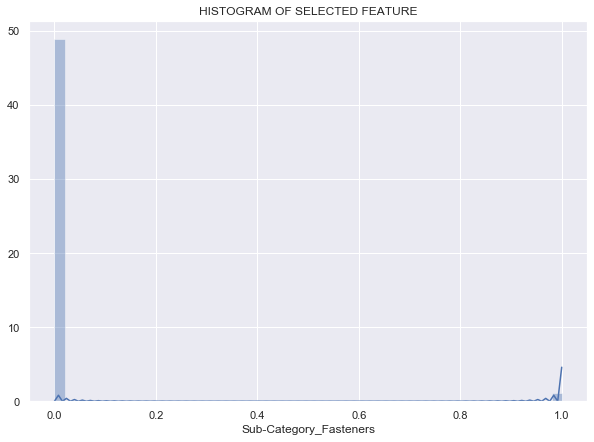

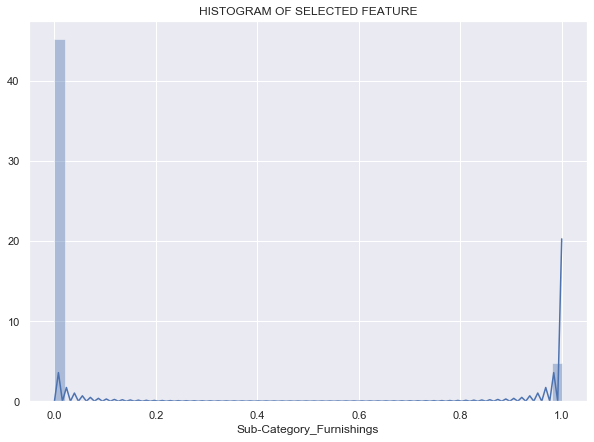

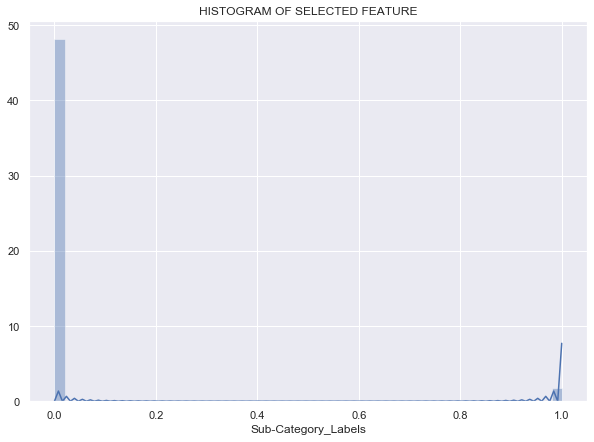

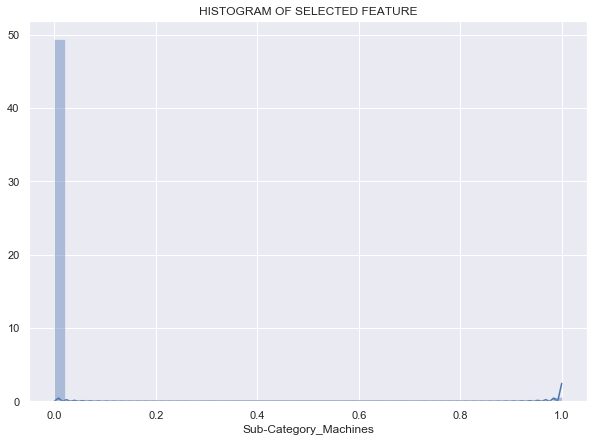

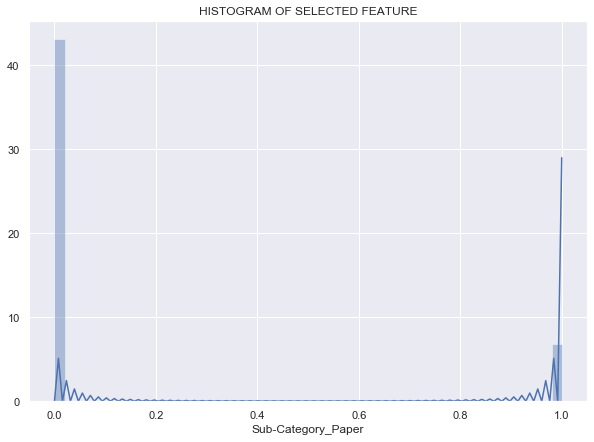

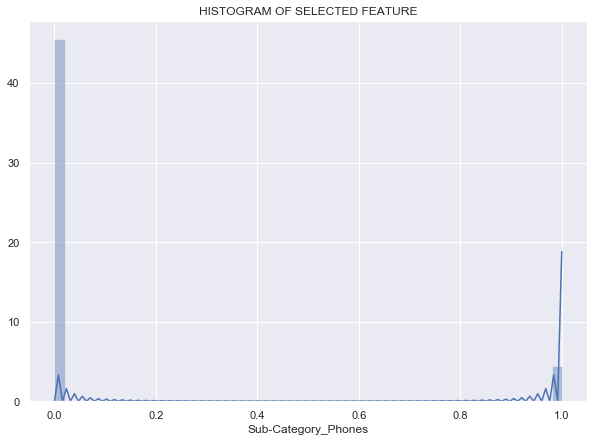

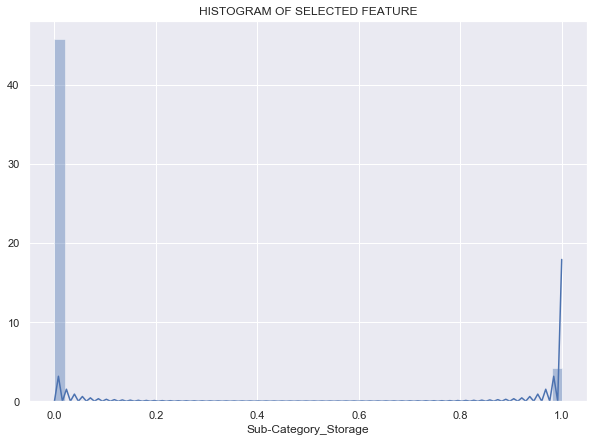

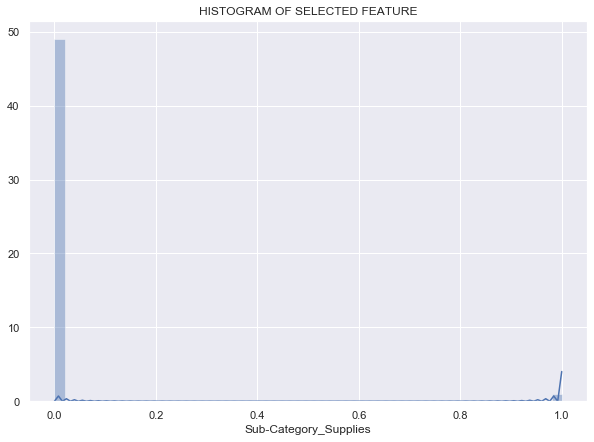

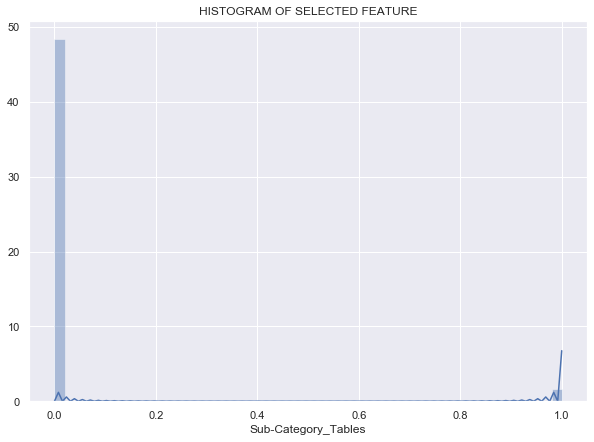

In [28]:
# show histogram plots of the features
features_all = data_scaled.columns
for feature in features_all:
    try:
        hist_plot(data_scaled, feature)
    except:
        pass

## Recency, Frequency, and Monetary (RFM) Assessment

In [29]:
print('THE DATES of INTEREST')
print('=====================')
columns = ['Order Date', 'Ship Date']
for col in columns:
    print('\n{}\nInitial: {}'.format(col, store_df[col].min()))
    print('Last:    {}'.format(store_df[col].max()))

THE DATES of INTEREST

Order Date
Initial: 2014-01-03 00:00:00
Last:    2017-12-30 00:00:00

Ship Date
Initial: 2014-01-07 00:00:00
Last:    2018-01-05 00:00:00


In [30]:
# Calculate RFM Features for Users at Each Checkpoint
Start_Date_Obj = dt.datetime.strptime("06/01/2017", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("12/30/2017", "%m/%d/%Y")
Time_Window = 60 #days. Only consider customers who have activities within the recent 60 days
FM_Window = 7 #days for frequency and monetary

RFM_Frame = rfm_result(Start_Date_Obj, End_Date_Obj, Time_Window, FM_Window)
RFM_Frame.head(50)

There are 194 unique users.
There are 196 unique users.
There are 199 unique users.
There are 199 unique users.
There are 204 unique users.
There are 204 unique users.
There are 203 unique users.
There are 199 unique users.
There are 202 unique users.
There are 200 unique users.
There are 203 unique users.
There are 207 unique users.
There are 211 unique users.
There are 209 unique users.
There are 207 unique users.
There are 208 unique users.
There are 209 unique users.
There are 214 unique users.
There are 216 unique users.
There are 217 unique users.
There are 216 unique users.
There are 217 unique users.
There are 216 unique users.
There are 211 unique users.
There are 211 unique users.
There are 211 unique users.
There are 216 unique users.
There are 216 unique users.
There are 215 unique users.
There are 212 unique users.
There are 215 unique users.
There are 213 unique users.
There are 212 unique users.
There are 217 unique users.
There are 214 unique users.
There are 209 unique

,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity
0,FH-14275,2017-06-01,19,0,0.00,0
1,AA-10480,2017-06-01,47,0,0.00,0
2,JK-16120,2017-06-01,21,0,0.00,0
3,DJ-13510,2017-06-01,24,0,0.00,0
4,TD-20995,2017-06-01,39,0,0.00,0
5,BM-11650,2017-06-01,19,0,0.00,0
6,CJ-12010,2017-06-01,31,0,0.00,0
7,LL-16840,2017-06-01,37,0,0.00,0
8,DM-13345,2017-06-01,54,0,0.00,0
9,TS-21655,2017-06-01,26,0,0.00,0


## K-Means Segmentation Model

In [31]:
# define the dataset variables required for clustering.
# note - TARGET DataFrame is derived at the beginning of this script.
X_scaled = RFM_Frame[['Recency', 'Frequency', 'Value']]

In [32]:
features = ['Value']   # scale this feature due to its larger magnitudes as compared to the other features

# scale the dataset
for feature in features:
    X_scaled[feature] = scale(X_scaled[feature])
print(X_scaled.head())

   Recency  Frequency     Value
0       19          0 -0.177315
1       47          0 -0.177315
2       21          0 -0.177315
3       24          0 -0.177315
4       39          0 -0.177315


C:\Users\NateDogg\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Elbow Method of Cluster Centers

In [33]:
''' REF: Python Machine Learning, Sebastian Raschka. Packt Publishing, 2015. Pg. 315, 320.'''
# derive a plot of a range of 'number of clusters' for the K-means algorithm
distortions = []   # within-cluster SSE, an intrinsic metric
range_val = range(1, 11)

for j in range_val:
    k_means_sym = KMeans(n_clusters=j,
                         init='k-means++',   # choose the best performing model in terms of the SSE (vs. 'k-means')
                         n_init=10,
                         max_iter=300,
                         random_state=random_var)
    k_result_sym = k_means_sym.fit(X_scaled)
    distortions.append(k_result_sym.inertia_)
    print('{} Cluster Distortion: {}'.format(j, np.round(k_result_sym.inertia_, 3)))

1 Cluster Distortion: 16014223.891
2 Cluster Distortion: 4107325.252
3 Cluster Distortion: 1877454.119
4 Cluster Distortion: 1087681.858
5 Cluster Distortion: 720818.721
6 Cluster Distortion: 522544.192
7 Cluster Distortion: 398814.007
8 Cluster Distortion: 312599.391
9 Cluster Distortion: 261991.506
10 Cluster Distortion: 225730.51


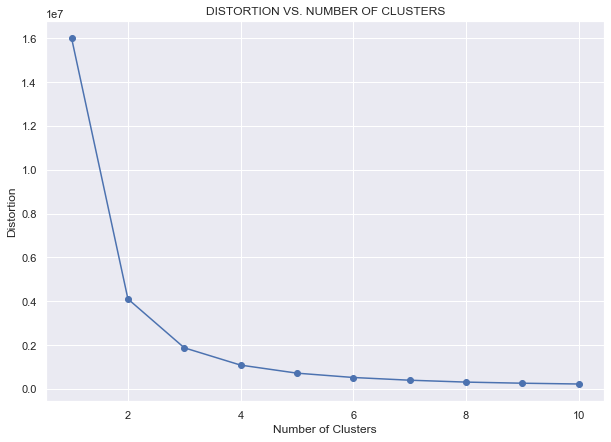

In [34]:
# plot the ELBOW results
plt.plot(range_val, distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('DISTORTION VS. NUMBER OF CLUSTERS')
plt.show()

### Silhouette Analysis of Cluster Centers

In [35]:
''' REF: Python Machine Learning, Sebastian Raschka. Packt Publishing, 2015. Pg. 320, 322-323.'''
# visually give another intrinsic metric of clustering
k_means = KMeans(n_clusters=3,
                 init='k-means++',   # choose the best performing model in terms of the SSE (vs. 'k-means')
                 n_init=10,
                 max_iter=300,
                 tol=1e-04,
                 random_state=random_var)
k_means = k_means.fit(X_scaled)
print('Distortion: {}'.format(np.round(k_means.inertia_, 3)))
k_means_result = k_means.predict(X_scaled)

Distortion: 1877454.119


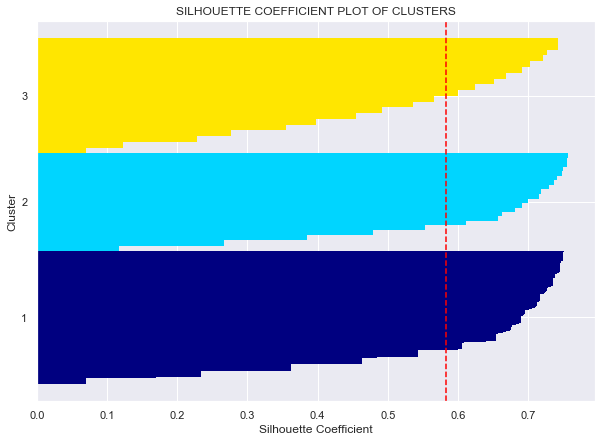

Silhouette Coefficient: 0.5831833407844241


In [39]:
# construct and plot a silhouette plot of the prescribed features
cluster_labels = np.unique(k_means_result)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_scaled,
                                     k_means_result,
                                     metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[k_means_result==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
           color='red',
           linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.title('SILHOUETTE COEFFICIENT PLOT OF CLUSTERS')
plt.show()
print('Silhouette Coefficient: {}'.format(silhouette_avg))

In [37]:
# assign the predicted clusters to the DataFrame
RFM_Frame['Cluster'] = pd.DataFrame(k_means_result)
RFM_Frame.head(50)

,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity,Cluster
0,FH-14275,2017-06-01,19,0,0.00,0,0
1,AA-10480,2017-06-01,47,0,0.00,0,1
2,JK-16120,2017-06-01,21,0,0.00,0,2
3,DJ-13510,2017-06-01,24,0,0.00,0,2
4,TD-20995,2017-06-01,39,0,0.00,0,2
5,BM-11650,2017-06-01,19,0,0.00,0,0
6,CJ-12010,2017-06-01,31,0,0.00,0,2
7,LL-16840,2017-06-01,37,0,0.00,0,2
8,DM-13345,2017-06-01,54,0,0.00,0,1
9,TS-21655,2017-06-01,26,0,0.00,0,2


## Conclusion

> ***OVERVIEW***  
> This assignment objective is primarily to derive a K-means segmentation of the existing customer base as provided from the supplied dataset. This result is based upon a Recency, Frequency, Monetary (RFM) assessment.  
<br>  
> ***DATASET PRE-WORK***  
> The dataset as presented here demonstrates additional work accomplished beyond what is required. In section 1.4 - Explore the Data, 2 constructs are derived that encode the dataset. Specifically, the first of these pertains to one-hot encoding of the 'Ship Mode', 'Segment', 'Region', 'Category', and 'Sub-Category' attributes. Beyond this, a specially curated label encoder is employed upon the 'Product ID' attribute. ALthough not required for the segmentation application, encoding reflects the lab contents that are demonstrated for student participation of Lesson 3. Thereafter, the dataset is scaled and consequently readied for machine learning model development where numerical values are the priority objective for further application. Furthermore, histogram plots are given of the scaled dataset for improved insight to the customer base data.  
<br>  
> ***RESULTS***  
> In Section 1.5 the RFM analysis is conducted and the results returned as a DataFrame whereupon the K-means segmentation is executed (Section 1.6). The segmentation is achieved via 3 feature clusters of the RFM results: 'Recency', 'Frequency', and 'Value'. Prior to choosing how many clusters to invoke upon the K-means model, an Elbow Plot is derived that resulted in an optimal input of 3 clusters. It should be noted that of the 3 aforementioned features, only 'Value' was scaled. Doing so gave a best Elbow Plot result, where in the other cases attempted for scaling, no significant 'elbow' was shown. Rather, a smoothed concave curve was the common output. The second segmentation assessment technique used is the Silhouette Analysis. For these results, it is observed that the silhouette coefficient is nearly .60 (on a scale of 0.0 to 1.0) and the horizontal bars are well clustered and not mixed with other clusters. These 2 assessments reflect a decently established K-Means segmentation result.  
<br>  
> For the client (superstore), the final result is shown as a DataFrame of the RFM results and the designated cluster designations thus derived. The specific cluster can thus be targeted by the client for increasing the business revenue according to these specified customer groupings.  
<br>  
> One last note of interest is that a 'K-means++' model is used here as apposed to the 'K-means' model directly. Doing so improves the clustering results, as well as returning such results more consistently.